In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## CLUPI optical distortion

Reference:

[CLUPI FM Geometric Calibration](./doc/CLUPI_FM_GeometricCalibration_20190805_V1.0.pdf)

[Open CV optical distortion]( https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html#camera-calibration-with-opencv)

<img src="./img/clupi_fovs.png" width="100" title="CLUPI context" />



In [131]:
width = 2652
half_width = width/2
height = 1768
half_height = height/2


calibration_results = {
'FICTIONAL' : {
    'fx': 13616.126338849,
    'fy': 13616.126338849,
    'cx': 1048.9536340664,
    'cy':  693.43003744259,
   'distortion' : [
    2.90795278846644,
   -1.81549917806834,
   -0.015467154966426,
   -0.024081314487023,
   -0.021714843651652    
    ]
},
    
    
'028CM' : {
    'fx': 13616.126338849,
    'fy': 13616.126338849,
    'cx': 1048.9536340664,
    'cy':  693.43003744259,
   'distortion' : [
    0.90795278846644,
   -0.81549917806834,
   -0.015467154966426,
   -0.024081314487023,
   -0.021714843651652    
    ]
},


'100CM' : {
    'fx': 12979.313699206,
    'fy': 12979.313699206,
    'cx': 1059.0009439107,
    'cy': 716.27511432891,
    
   'distortion' : [
     0.82640045036451,
    -0.80990580903775,
    -0.013565578400063,
    -0.020481752564741,
    -0.024481529915831

    ]
},

'250CM' : {

    'fx': 13167.381556084,
    'fy': 13167.381556084,
    'cx': 1488.0073428712,
    'cy': 1090.7177140844,
   'distortion' : [
     0.84478595905046,
    -0.77452686325751,
     0.016311335023569,
     0.013922403608605,
     0.040406969232604
    ]
}
    
}


def get_correction_matrix(calibration):
    k1, k2, p1, p2, k3 = calibration['distortion']

    cx = calibration['cx']
    cy = calibration['cy']

    fx = calibration['fx']
    fy = calibration['fy']

    u, v = np.meshgrid(np.arange(0, width), np.arange(0, height))


    xp =  (u - cx) / fx
    yp =  (v - cy) / fy

    r_2 = np.power(xp, 2) + np.power(yp, 2) 

    rho = 1  + k1 * r_2  + k2 * np.power(r_2, 2) + k3 * np.power(r_2, 3)


    htg_1 =  (2 * p1 * xp * yp) 
    htg_2 =  (p2 * (r_2 + 2 * np.power(xp, 2)))
    xpp = (xp * rho) + htg_1 + htg_2

    vtg_1 =  (2 * p2 * xp * yp) 
    vtg_2 =  (p1 * (r_2 + 2 * np.power(yp, 2))) 
    ypp = yp * rho + vtg_1 + vtg_2


    up = ((xpp * fx) + cx)
    vp = ((ypp * fy) + cy)

    hcorr = up - u
    vcorr = vp - v

    return hcorr, vcorr




\begin{equation*} \rho = 1+ K_1r^2 + K_2r^4 + K_3r^6\end{equation*}
\begin{equation*} r^2 = x'^2 + y'^2 \end{equation*}
\begin{equation*} x" = x' \rho + 2P_1x'y' + P_2(r^2 + 2x'^2) \end{equation*}
\begin{equation*} y" = y' \rho + P_1(r^2 + 2y'^2) + 2P_2x'y' \end{equation*}



FICTIONAL
Horizontal Correction: -42.10 72.72
Vertical Correction:   -33.43 48.91

028CM
Horizontal Correction: -16.76 11.61
Vertical Correction:   -10.82 10.52

100CM
Horizontal Correction: -16.14 12.95
Vertical Correction:   -11.18 10.20

250CM
Horizontal Correction: -14.08 16.88
Vertical Correction:   -9.91 10.99


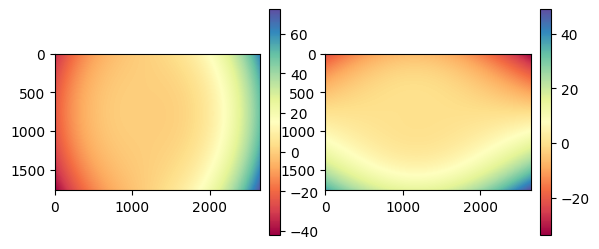

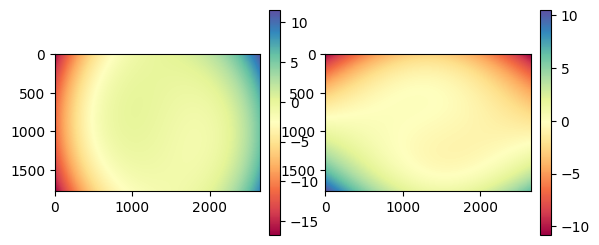

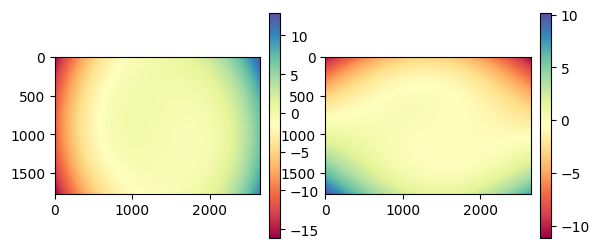

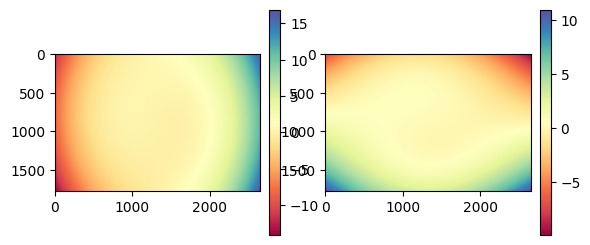

In [132]:

for focal_distance in calibration_results.keys():
    calibration = calibration_results[focal_distance]
    print()
    print(focal_distance)
    print('=' * 35)

    hcorr, vcorr = get_correction_matrix(calibration)
    
    print(f'Horizontal Correction: {hcorr.min():.2f} {hcorr.max():.2f}')
    print(f'Vertical Correction:   {vcorr.min():.2f} {vcorr.max():.2f}')

    cmap_name = 'Spectral'
    
    fig, ((subplot_1, subplot_2)) = plt.subplots(1, 2)
    im_1 = subplot_1.imshow(hcorr, cmap=cmap_name)
    plt.colorbar(im_1, ax=subplot_1,fraction=0.05, pad=0.04)
    im_2 = subplot_2.imshow(vcorr, cmap=cmap_name)
    plt.colorbar(im_2, ax=subplot_2,fraction=0.05, pad=0.04)




255
(1768, 2652)
(1768, 2652)
(1851, 2767)
432981
(1768, 2652)


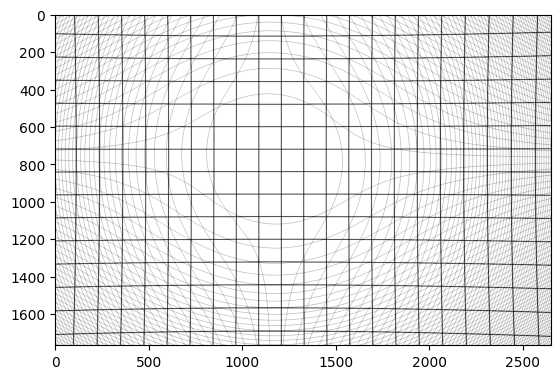

In [137]:
from PIL import Image
fname = 'grid.png'
original = Image.open(fname)
pix = np.array(original)
pix = pix[:,:,0]

focal_distance = 'FICTIONAL'
cal = calibration_results[focal_distance]
pheight, pwidth = pix.shape

hcorr, vcorr = get_correction_matrix(cal) 

x_min = 0 + np.min(hcorr.min(), 0)
y_min = 0 + np.min(vcorr.min(), 0)
ext_x_0 =  np.floor(-1 * hcorr.min()).astype(int)
ext_y_0 =  np.floor(-1 * vcorr.min()).astype(int)

x_max = pwidth + hcorr.max()
y_max = pheight + vcorr.max()

ext_width = np.ceil(x_max - x_min).astype(int)
ext_height = np.ceil(y_max - y_min).astype(int)

ext = np.ones((ext_height, ext_width)) * 0

print(pix.max())
print(hcorr.shape)
print(vcorr.shape)
print(ext.shape)
corrected = set()
for i in range(0, width):
    for j in range(0, height):
        ci = np.round(i + hcorr[j][i]).astype(int) + ext_x_0
        cj = np.round(j + vcorr[j][i]).astype(int) + ext_y_0
        ext[cj][ci] =  pix[j][i]
        corrected.add(f'{cj}_{ci}')

print((ext_width * ext_height) - len(corrected) )

distorted_img = ext[ext_y_0:ext_y_0+height, ext_x_0:ext_x_0+width]
print(distorted_img.shape)


plt.imshow(distorted_img, cmap='gray')

distorted = Image.fromarray(distorted_img)
distorted = distorted.convert("L")
distorted.save('distorted_grid.png')


In [130]:
def spice_entry(inst_code, fd, key, value):
    spice_key = f'INST{inst_code}_{fd}_{key}'
    return f'{" " * 9}{spice_key:22s} = ({value})'

inst_code = '-174601'
for focal_distance in calibration_results.keys():
    calibration =  calibration_results[focal_distance]
    k1, k2, p1, p2, k3 = calibration['distortion']

    cx = calibration['cx']
    cy = calibration['cy']

    fx = calibration['fx']
    fy = calibration['fy']
    
    print(spice_entry(inst_code, focal_distance, 'CX', cx))
    print(spice_entry(inst_code, focal_distance, 'CY', cy))
    print(spice_entry(inst_code, focal_distance, 'FX', fx))
    print(spice_entry(inst_code, focal_distance, 'FY', fy))
    print(spice_entry(inst_code, focal_distance, 'K1', k1))
    print(spice_entry(inst_code, focal_distance, 'K2', k2))
    print(spice_entry(inst_code, focal_distance, 'P1', p1))
    print(spice_entry(inst_code, focal_distance, 'P2', p2))
    print(spice_entry(inst_code, focal_distance, 'K3', k3))
    
    print()

         INST-174601_FICTIONAL_CX = (1048.9536340664)
         INST-174601_FICTIONAL_CY = (693.43003744259)
         INST-174601_FICTIONAL_FX = (13616.126338849)
         INST-174601_FICTIONAL_FY = (13616.126338849)
         INST-174601_FICTIONAL_K1 = (2.90795278846644)
         INST-174601_FICTIONAL_K2 = (-0.81549917806834)
         INST-174601_FICTIONAL_P1 = (-0.015467154966426)
         INST-174601_FICTIONAL_P2 = (-0.024081314487023)
         INST-174601_FICTIONAL_K3 = (-0.021714843651652)

         INST-174601_028CM_CX   = (1048.9536340664)
         INST-174601_028CM_CY   = (693.43003744259)
         INST-174601_028CM_FX   = (13616.126338849)
         INST-174601_028CM_FY   = (13616.126338849)
         INST-174601_028CM_K1   = (0.90795278846644)
         INST-174601_028CM_K2   = (-0.81549917806834)
         INST-174601_028CM_P1   = (-0.015467154966426)
         INST-174601_028CM_P2   = (-0.024081314487023)
         INST-174601_028CM_K3   = (-0.021714843651652)

         INST-174601

255
(1768, 2652)
(1768, 2652)
(1851, 2767)
682294
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1768, 2652)


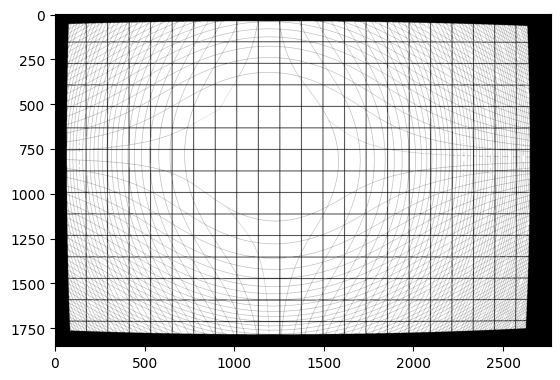

In [141]:
fname = 'distorted_grid.png'
original = Image.open(fname)
pix = np.array(original)


focal_distance = 'FICTIONAL'
cal = calibration_results[focal_distance]
pheight, pwidth = pix.shape

hcorr, vcorr = get_correction_matrix(cal) 

x_min = 0 + np.min(hcorr.min(), 0)
y_min = 0 + np.min(vcorr.min(), 0)
ext_x_0 =  np.floor(-1 * hcorr.min()).astype(int)
ext_y_0 =  np.floor(-1 * vcorr.min()).astype(int)

x_max = pwidth + hcorr.max()
y_max = pheight + vcorr.max()

ext_width = np.ceil(x_max - x_min).astype(int)
ext_height = np.ceil(y_max - y_min).astype(int)

ext = np.ones((ext_height, ext_width)) * 0

print(pix.max())
print(hcorr.shape)
print(vcorr.shape)
print(ext.shape)
corrected = set()
for i in range(0, width):
    for j in range(0, height):
        ci = np.round(i - hcorr[j][i]).astype(int) + ext_x_0
        cj = np.round(j - vcorr[j][i]).astype(int) + ext_y_0
        ext[cj][ci] =  pix[j][i]
        corrected.add(f'{cj}_{ci}')

print((ext_width * ext_height) - len(corrected) )


print(ext)


plt.imshow(ext, cmap='gray')


corrected = ext[ext_y_0:ext_y_0+height, ext_x_0:ext_x_0+width]
print(corrected.shape)




corrected_img = Image.fromarray(corrected)
corrected_img = corrected_img.convert("L")
corrected_img.save('corrected.png')